In [1]:
import pandas as pd
from specq_jax.core import whitebox, calculate_expvals, calculate_expvals, plot_expvals, signal, rotating_duffling_oscillator_hamiltonian, get_simulator
from specq_jax.pulse import DragPulse, JaxBasedPulseSequence
import specq_dev.specq.shared as specq
from specq_dev.specq.qiskit import get_ibm_service_and_backend
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pennylane as qml
from typing import Callable
from IPython.display import Latex

In [14]:
def rotating_transmon_hamiltonian(
    qubit_info: specq.QubitInformationV3, signal: Callable
):
    a0 = 2 * jnp.pi * qubit_info.frequency
    a1 = 2 * jnp.pi * qubit_info.drive_strength

    f3 = lambda params, t: a1 * signal(params, t)
    f_sigma_x = lambda params, t: f3(params, t) * jnp.cos(a0 * t)
    f_sigma_y = lambda params, t: -1 * f3(params, t) * jnp.sin(a0 * t) / 2  # NOTE: WHY?

    return f_sigma_x * qml.PauliX(0) + f_sigma_y * qml.PauliY(0)

direct_waveform = lambda params, t, phase, qubit_freq, total_time_ns: qml.pulse.pwc(
    (0, total_time_ns)
)(params, t)

def naive_hamiltonian(qubit_info: specq.QubitInformationV3, signal: Callable):

    a1 = 2 * jnp.pi * qubit_info.drive_strength

    f3 = lambda params, t: -1 * a1 * signal(params, t) / 2

    return f3 * qml.PauliX(0)
def get_simulator_v2(
    qubit_info: specq.QubitInformationV3,
    t_eval: jnp.ndarray,
    signal: Callable,
    hamiltonian: Callable[
        [specq.QubitInformationV3, Callable],
        qml.pulse.parametrized_hamiltonian.ParametrizedHamiltonian,
    ] = rotating_duffling_oscillator_hamiltonian,
):
    fixed_freq_signal = lambda params, t: signal(
        params,
        t,
        0,
        qubit_info.frequency,
        t_eval[-1],
    )

    H = hamiltonian(qubit_info, fixed_freq_signal)
    num_parameterized = len(H.coeffs_parametrized)

    simulator = lambda params: whitebox(params, t_eval, H, num_parameterized)

    return simulator


def plot_result(
    unitaries,
    results_df,
    exp_config,
    t_eval_simulator,
):

    expvals = calculate_expvals(unitaries)

    fig, axes = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(18, 9))

    for idx, exp in enumerate(specq.default_expectation_values):
        rows = results_df.loc[
            (results_df["initial_state"] == exp.initial_state)
            & (results_df["observable"] == exp.observable)
        ][["duration", "expectation_value"]]

        values = rows.values

        t = values[:, 0] * exp_config.device_cycle_time_ns
        y = values[:, 1]

        dt = exp_config.device_cycle_time_ns
        total_length = exp_config.sequence_duration_dt

        y_simulator = expvals[idx]

        ax = axes[idx // 6, idx % 6]
        ax.plot(t, y, "o", label="IBM")
        ax.plot(t_eval_simulator, y_simulator, label="Simulator")

        ax.set_title(f"{exp.initial_state} -> {exp.observable}")

        ax.legend()
    return fig

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


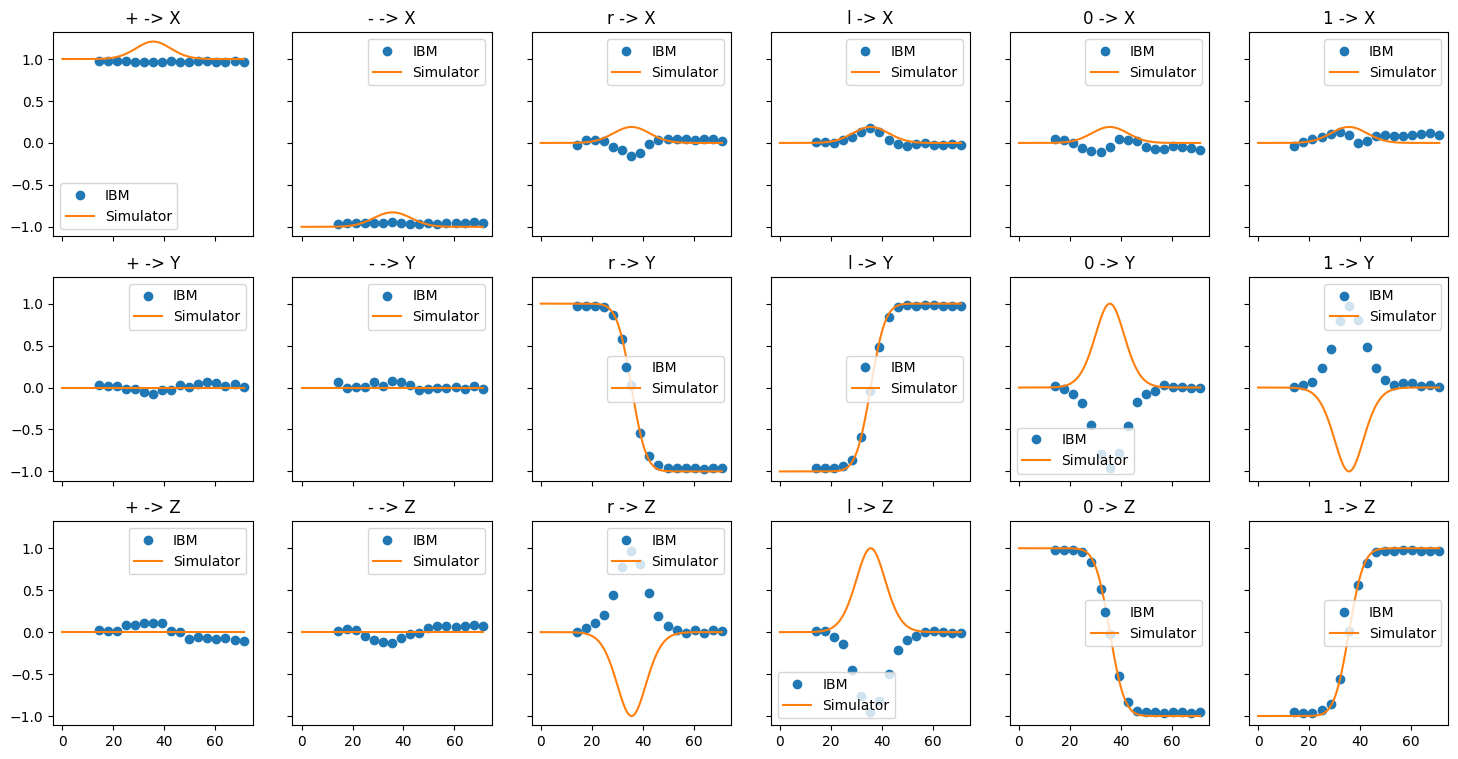

In [16]:
PATH = "../tests/test_data/drag_0001/"

exp_config = specq.ExperimentConfigV3.from_file(PATH)
qubit_info = exp_config.qubits[0]
pulse_sequence = JaxBasedPulseSequence.from_file(PATH, pulses=[DragPulse])
result_df = pd.read_csv(PATH + "data.csv")

# The original expectation value without MCMD could be calculate using
# columns "quasi_dist/2" + "quasi_dist/0" - "quasi_dist/1" - "quasi_dist/3"
# result_df["expectation_value"] = result_df["quasi_dist/2"] + result_df["quasi_dist/0"] - result_df["quasi_dist/1"] - result_df["quasi_dist/3"]
# result_df["expectation_value"] = result_df["quasi_dist/1"] + result_df["quasi_dist/3"] - result_df["quasi_dist/0"] - result_df["quasi_dist/2"]

t_eval = jnp.linspace(0, exp_config.sequence_duration_dt * exp_config.device_cycle_time_ns, exp_config.sequence_duration_dt)
simulator = get_simulator_v2(qubit_info, t_eval, direct_waveform, naive_hamiltonian)
# simulator = get_simulator_v2(qubit_info, t_eval, signal, rotating_duffling_oscillator_hamiltonian)
key = jax.random.PRNGKey(0)
params = pulse_sequence.sample_params(key)
waveforms = [pulse_sequence.get_waveform(params)]
unitaries = simulator(waveforms[-1])

fig = plot_result(unitaries, result_df, exp_config, t_eval)

In [12]:
def get_rotating_unitary(t, qubit_info: specq.QubitInformationV3):
    return jnp.array(
        [
            [
                jnp.exp(1j * 2 * jnp.pi * qubit_info.frequency * t / 2),
                0,
            ],
            [0, jnp.exp(-1j * 2 * jnp.pi * qubit_info.frequency * t / 2)],
        ]
    )

get_rotating_unitary_with_qubit_info = lambda t: get_rotating_unitary(t, qubit_info)

rotating_unitaries = jax.vmap(get_rotating_unitary_with_qubit_info)(t_eval)
# complex conjugate transpose of batch of unitaries
rotating_unitaries_dagger = jnp.conj(jnp.transpose(rotating_unitaries, (0, 2, 1)))
# Check identity
to_be_check = jnp.matmul(rotating_unitaries, rotating_unitaries_dagger)
# Assert allclose to identity
assert jnp.allclose(to_be_check, jnp.eye(2))

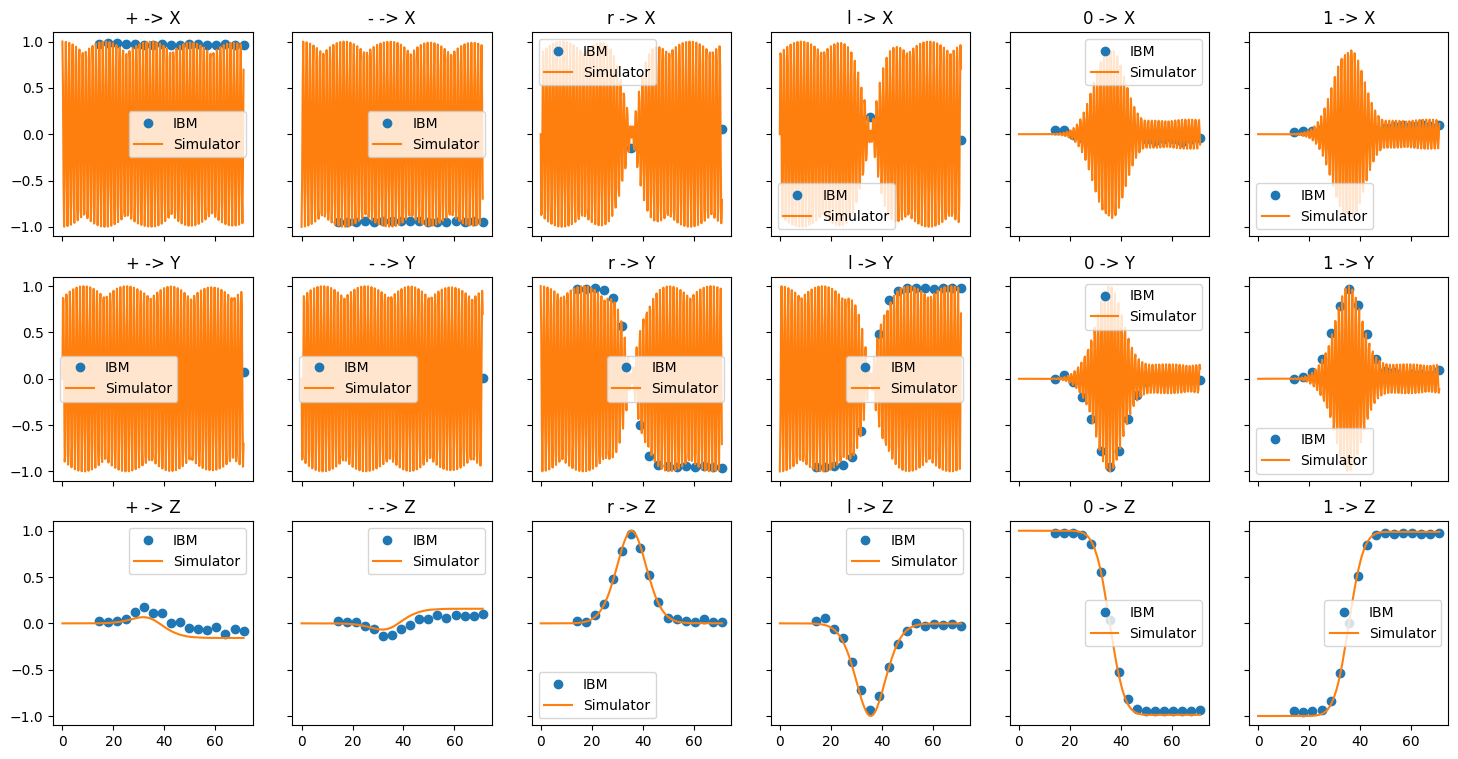

In [13]:
transformed_unitaries = jnp.matmul(rotating_unitaries_dagger, unitaries)
fig = plot_result(transformed_unitaries, result_df, exp_config, t_eval)

In [12]:
instance = "utokyo-kawasaki/keio-internal/keio-students"
backend_name = "ibm_kawasaki"

service, backend = get_ibm_service_and_backend(instance, backend_name)

In [13]:
Latex(backend.configuration().hamiltonian["h_latex"])

<IPython.core.display.Latex object>